In [2]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from models import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *
import datetime as dt
from simulation_func import *
import pandas as pd
import pickle as pkl
import os
from math import sqrt
import simulation_func
import logging

# Running the Simulations

## Run without early stop

- First writing the stopping condition
    - integration will stop if steady state is reached
    - the tolerance will be `tol=1e-9`



- Setting 25 species, 50 resources
- 100 simulations were performed

In [4]:
# Setting parametres
N = 50
M = 100
assemblenum = 1
para = Paras(N, M)
assemblies = 1

In [5]:
p, number = int_preferences(N, M, para.mu_c, assemblenum)
D = int_conversion(M, para.Dbase, para.number, assemblenum, para.sparsity)
l = int_l(M, para.l_base, assemblenum)
rho = int_rho(M, para.rho_base, assemblenum)
vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
m = int_mt(N, para.m_base, assemblenum)
avgm = allocate_avgm(N, para.w, assemblenum, para.ymin, para.ymax)

In [6]:
Rt_assemblies = []
Ct_assemblies = []
time_assemblies = []
para_assemblies = []

In [7]:
# Run simulation
start = dt.datetime.now()
for i in range(assemblies):
    Rt, Ct, t, para = sim_run(N, M, para, i, tstop=50000, teval=10000)
    Rt_assemblies.append(Rt)
    Ct_assemblies.append(Ct)
    para_assemblies.append(para)
    time_assemblies.append(t)
    print(f'Asembly {i+1} complete, runtime:{dt.datetime.now()-start}') if (i+1) %5==0 else None

### Store the data

- Each Assembly will be stored in a dir called 'Abl_n' containing four files:
    - Resource concentration -- Abl_n_Rt.npy
    - Biomass concentration -- Abl_n_Ct.npy
    - Parametre -- Abl_n_Para.pkl
    - Time_series -- Abl_n_t.npy

In [ ]:
if not os.path.exists('..\Data\Asb'):
    os.makedirs('..\Data\Asb')
for i in range(1, len(Ct_assemblies)+1):

    dir = f'..\Data\Asb\Abl_{i}'
    if not os.path.exists(dir):
        os.makedirs(dir) 

    with open(dir + f'\Abl_{i}_Ct.npy', 'wb') as f:
        np.save(f, Ct_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_Rt.npy', 'wb') as f:
        np.save(f, Rt_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_t.npy', 'wb') as f:
        np.save(f, time_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_Para.pkl', 'wb') as f:
        pkl.dump(para_assemblies[i-1], f)
    f.close()

# Stopping at Equlibrium state

In [ ]:
# Setting parametres
N = 100
M = 100
subcommunity_size = 50
num_subcommunity = 10
tol = 1e-8

In [ ]:
# Run simulation
Rt_assemblies, Ct_assemblies, time_assemblies, para_assemblies, idx_assemblies = sim_sub_run_tol(N, M, 1, tstop=10e5, teval=10000, subcommunity_size=subcommunity_size, num_subcommunity=num_subcommunity, tol=tol)

Initialisation completed!
Subcommunity simulation 5 completed runtime:0:00:00.125623
Subcommunity simulation 10 completed runtime:0:00:00.263293


In [ ]:
if not os.path.exists('..\Data\eqAsb'):
    os.makedirs('..\Data\eqAsb')
for i in range(1, len(Ct_assemblies)+1):

    dir = f'..\Data\eqAsb\eqAbl_{i}'
    if not os.path.exists(dir):
        os.makedirs(dir) 

    with open(dir + f'\eqAbl_{i}_Ct.npy', 'wb') as f:
        np.save(f, Ct_assemblies[i-1])
    f.close()

    with open(dir + f'\eqAbl_{i}_Rt.npy', 'wb') as f:
        np.save(f, Rt_assemblies[i-1])
    f.close()

    with open(dir + f'\eqAbl_{i}_t.npy', 'wb') as f:
        np.save(f, time_assemblies[i-1])
    f.close()

    with open(dir + f'\eqAbl_{i}_Para.pkl', 'wb') as f:
        pkl.dump(para_assemblies[i-1], f)
    f.close()

    with open(dir + f'\Abl_{i}_ID.npy', 'wb') as f:
        np.save(f, idx_assemblies[i-1])
    f.close()

## Subassemby runs without terminating conditions

In [ ]:
# Setting parametres
N = 100
M = 100
assemblenum = 1
assemblies = 10
subcommunity_size = 0
num_subcommunity = 30

In [ ]:
R, C, t, para, idlist = sim_sub_run(N, M, assemblenum, 400000, 10000, subcommunity_size, num_subcommunity)

Initialisation completed!
Subcommunity simulation 5 completed runtime:0:00:00.090379
Subcommunity simulation 10 completed runtime:0:00:00.176964
Subcommunity simulation 15 completed runtime:0:00:00.273563
Subcommunity simulation 20 completed runtime:0:00:00.362147
Subcommunity simulation 25 completed runtime:0:00:00.455363
Subcommunity simulation 30 completed runtime:0:00:00.550488


### Load data structure
- data storage structure: FOLDER `sub_abl_beta=0.75` contains
    - FOLDER `subabl_{i}`, each of which contains the following:
        - Resource concentration -- `sAbl_n_Rt.npy`
        - Biomass concentration -- `sAbl_n_Ct.npy`
        - Parametre -- `sAbl_n_Para.pkl`
        - Time_series -- `sAbl_n_t.npy`

In [ ]:
if not os.path.exists('..\Data\sub'):
    os.makedirs('..\Data\sub')
for i in range(1, num_subcommunity+1):

    dir = f'..\Data\sub\sAbl_{i}'
    if not os.path.exists(dir):
        os.makedirs(dir) 

    with open(dir + f'\sAbl_{i}_Ct.npy', 'wb') as f:
        np.save(f, C[i-1])
    f.close()

    with open(dir + f'\sAbl_{i}_Rt.npy', 'wb') as f:
        np.save(f, R[i-1])
    f.close()

    with open(dir + f'\sAbl_{i}_t.npy', 'wb') as f:
        np.save(f, t[i-1])
    f.close()

    with open(dir + f'\sAbl_{i}_Para.pkl', 'wb') as f:
        pkl.dump(para[i-1], f)
    f.close()

    with open(dir + f'\sAbl_{i}speciesID.npy', 'wb') as f:
        np.save(f, idlist[i-1])
    f.close()

KeyboardInterrupt: 

## Subassemby runs with varying w

- let `w=1` to `w=2` from uniform to left skewed distribution
- Assuming each community has `subcommunity_size = 30` species selected from a pre-initialised species pool, each session consists of 30 communities for each value of `w`, where `w` will be binned into `50` values.
- Modify `sim_sub_run` function, then we store our results

In [ ]:
## get w values
w = np.linspace(1, 2, 50)

## initialised data storage
Rw = []
Cw = []
tw = []
paraw = []
idlist = []

## initialised parametres
N = 100
M = 100
assemblenum = 1
assemblies = 30
subcommunity_size = 50
num_subcommunity = 30

In [ ]:
### initialised parametres to ensure each session uses the same set of species
para = Paras(N, M)
p, number = int_preferences(N, M, para.mu_c, assemblenum)
D = int_conversion(M, para.Dbase, para.number, assemblenum, para.sparsity)
l = int_l(M, para.l_base, assemblenum)
rho = int_rho(M, para.rho_base, assemblenum)
vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
m = int_mt(N, para.m_base, assemblenum)

In [ ]:
def sim_sub_run(N, M, assemblenum, tstop, teval, subcommunity_size=10, num_subcommunity=20, scale=True, w=2):

    # data storage
    R_assembles = []
    C_assembles = []
    t_assembles = []
    para_assembles = []
    identifiers = []
    model = Paras(N, M)
    avgm_global = allocate_avgm(N, w, assemblenum, model.ymin, model.ymax)

    # print(f'Initialisation completed!')
    # start = dt.datetime.now()

    # run sub_communities
    for i in range(num_subcommunity):

        para = Paras(subcommunity_size, M)
        ## select corresponding species for subcommunity assemblies
        rng = default_rng(seed=assemblenum+i+8*i)
        idx = rng.choice(range(N), size=subcommunity_size, replace=False)
        identifiers.append(idx)

        # reset and initialised
        new_p = p[idx, :]
        new_vmax = vmax[idx, :]
        new_m = m[idx, :]
        para.w = w
        avgm = avgm_global[idx]
        # print(avgm)
        ## Initialised Initial conditions
        R0 = int_R(M, para.R0, assemblenum)
        C0 = int_C(avgm, para.x0)

       # Load parametres
        para.paras(C0, R0, l, rho, new_p, new_vmax, new_m, D, avgm)
        time = np.linspace(0, tstop, teval)
        y0 = np.concatenate((R0, C0)).reshape(M+subcommunity_size,) # initial conditions
        # run and store
        if scale:
            pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.beta, para.gamma, para.R_half, para.avgm)
            result = solve_ivp(
            odes_scale_size, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)
        
        if not scale:
            pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.R_half)
            result = solve_ivp(odes_not_scaled, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)
        
        Rt = result['y'][0:M]
        Ct = result['y'][M:M+subcommunity_size]
        t = result['t']

        # print(f'Subcommunity simulation {i+1} completed runtime:{dt.datetime.now()-start}') if (i+1)%5==0 else None

        R_assembles.append(Rt)
        C_assembles.append(Ct)
        t_assembles.append(t)
        para_assembles.append(para)

    return R_assembles, C_assembles, t_assembles, para_assembles, identifiers

In [ ]:
# start running

start = dt.datetime.now()
for i, vals in enumerate(w):
    R, C, t, parat, idxs = sim_sub_run(N, M, i, 50000, 10000, subcommunity_size, num_subcommunity, True, vals)
    Rw.append(R)
    Cw.append(C)
    tw.append(t)
    paraw.append(parat)
    idlist.append(idxs)
    
    print(f'Subcommunity simulation {i+1} completed runtime:{dt.datetime.now()-start}, w: {parat[0].w}')  if (i+1)%5==0 else None


Subcommunity simulation 5 completed runtime:0:09:42.743656, w: 1.0816326530612246
Subcommunity simulation 10 completed runtime:0:20:49.418348, w: 1.183673469387755
Subcommunity simulation 15 completed runtime:0:33:19.030816, w: 1.2857142857142856
Subcommunity simulation 20 completed runtime:0:46:44.858641, w: 1.3877551020408163
Subcommunity simulation 25 completed runtime:1:01:17.858204, w: 1.489795918367347
Subcommunity simulation 30 completed runtime:1:15:15.870946, w: 1.5918367346938775
Subcommunity simulation 35 completed runtime:1:29:33.073026, w: 1.693877551020408
Subcommunity simulation 40 completed runtime:1:45:58.217434, w: 1.7959183673469385
Subcommunity simulation 45 completed runtime:2:03:47.493588, w: 1.8979591836734693
Subcommunity simulation 50 completed runtime:2:18:56.374703, w: 2.0


- data storage structure: FOLDER `variedC` contains
    - FOLDER `w_val`, each of which contains the following:
        - Resource concentration -- `sAbl_n_Rt.npy`
        - Biomass concentration -- `sAbl_n_Ct.npy`
        - Parametre -- `sAbl_n_Para.pkl`
        - Time_series -- `sAbl_n_t.npy` $\newline$
for every n

In [ ]:
## data storage
if not os.path.exists('..\Data\\variedC'):
    os.mkdir('..\Data\\variedC')

for i, val in enumerate(w):

    if 40 <= i < 50:

        dir = f'..\Data\\variedC\w_{i+1}'
        if not os.path.exists(dir): os.mkdir(dir)
        
        R = Rw[i]
        C = Cw[i]
        t = tw[i]
        para = paraw[i]
        idl = idlist[i]

        for j in range(1, len(R)+1):
            with open(dir + f'\w{i+1}_sAbl_{j}_Ct.npy', 'wb') as f:
                np.save(f, C[j-1])
            f.close()

            with open(dir + f'\w{i+1}_sAbl_{j}_Rt.npy', 'wb') as f:
                np.save(f, R[j-1])
            f.close()

            with open(dir + f'\w{i+1}_sAbl_{j}_t.npy', 'wb') as f:
                np.save(f, t[j-1])
            f.close()

            with open(dir + f'\w{i+1}_sAbl_{j}_Para.pkl', 'wb') as f:
                pkl.dump(para[j-1], f)
            f.close()

            with open(dir + f'\w{i+1}_sAbl_{j}_speciesID.npy', 'wb') as f:
                np.save(f, idl[j-1])
            f.close()

    else:
        pass


## Assemby runs with varying w (without early stop)

In [ ]:
N = 50
M = 100
paras = Paras(N, M)
tol=1e-3

In [ ]:
def sim_run_tols(N, M, para:Paras, assemblenum, tstop, teval, scale=True, tol=1e-4, w=2):

    ### initialised parametres with equilibrium early stop
    # para = Paras(N, M)
    p, number = int_preferences(N, M, para.mu_c, assemblenum)
    D = int_conversion(M, para.Dbase, para.number, assemblenum, para.sparsity)
    l = int_l(M, para.l_base, assemblenum)
    rho = int_rho(M, para.rho_base, assemblenum)
    vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
    m = int_mt(N, para.m_base, assemblenum)
    para.w = w
    avgm = allocate_avgm(N, w, assemblenum, para.ymin, para.ymax)

    ## Initialised Initial conditions
    R0 = int_R(M, para.R0, assemblenum)
    C0 = int_C(avgm, para.x0)

    # Load parametres
    para.paras(C0, R0, l, rho, p, vmax, m, D, avgm)
    time = np.linspace(0, tstop, teval)
    y0 = np.concatenate((R0, C0)).reshape(M+N,) # initial conditions

    # run and store
    if scale:
        pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.beta, para.gamma, para.R_half, para.avgm)

        odec = lambda t, y:odes_scale_size(t, y, *pars)
        detect_ss_odec = lambda t, y: detect_steady_state(t, y,*pars, tol, N)
        detect_ss_odec.terminal = True
        # detect_ss_odec.direction = 0
        
        result = solve_ivp(
        odes_scale_size, t_span=[time[0], time[-1]], args=pars, y0=y0, t_eval=time, dense_output=True)
    
    if not scale:
        pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.R_half)
        result = solve_ivp(odes_not_scaled, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)

    Rt = result['y'][0:M]
    Ct = result['y'][M:M+N]
    t = result['t']
    # Ct = extract_Ct_single_assembly(Ct)
    
    return Rt, Ct, t, para

In [ ]:
RtA = []
CtA = []
ttA = []
paraA = []

In [ ]:
warray = np.linspace(1, 2, 50)
start = dt.datetime.now()
for i, w in enumerate(warray):
    R, C, t, para = sim_run_tols(N, M, paras, 1, 50000, 10000, tol=tol, w=w)
    RtA.append(R)
    CtA.append(C)
    ttA.append(t)
    paraA.append(para)
    print(f'Subcommunity simulation {i+1} completed runtime:{dt.datetime.now()-start}, w: {para.w}') if (i+1)%5==0 else None

Subcommunity simulation 5 completed runtime:0:21:17.931479, w: 1.0816326530612246
Subcommunity simulation 10 completed runtime:0:45:56.496456, w: 1.183673469387755
Subcommunity simulation 15 completed runtime:1:11:54.493662, w: 1.2857142857142856
Subcommunity simulation 20 completed runtime:1:36:51.331152, w: 1.3877551020408163
Subcommunity simulation 25 completed runtime:2:00:05.537662, w: 1.489795918367347
Subcommunity simulation 30 completed runtime:2:22:38.518108, w: 1.5918367346938775
Subcommunity simulation 35 completed runtime:2:44:20.217230, w: 1.693877551020408
Subcommunity simulation 40 completed runtime:3:07:01.145699, w: 1.7959183673469385
Subcommunity simulation 45 completed runtime:3:28:59.860883, w: 1.8979591836734693
Subcommunity simulation 50 completed runtime:3:50:23.725077, w: 2.0


In [ ]:
warray

array([1.        , 1.02040816, 1.04081633, 1.06122449, 1.08163265,
       1.10204082, 1.12244898, 1.14285714, 1.16326531, 1.18367347,
       1.20408163, 1.2244898 , 1.24489796, 1.26530612, 1.28571429,
       1.30612245, 1.32653061, 1.34693878, 1.36734694, 1.3877551 ,
       1.40816327, 1.42857143, 1.44897959, 1.46938776, 1.48979592,
       1.51020408, 1.53061224, 1.55102041, 1.57142857, 1.59183673,
       1.6122449 , 1.63265306, 1.65306122, 1.67346939, 1.69387755,
       1.71428571, 1.73469388, 1.75510204, 1.7755102 , 1.79591837,
       1.81632653, 1.83673469, 1.85714286, 1.87755102, 1.89795918,
       1.91836735, 1.93877551, 1.95918367, 1.97959184, 2.        ])

In [ ]:
if not os.path.exists('..\Data\\varyw'):
    os.mkdir('..\Data\\varyw')

for i, val in enumerate(warray):

    dir = f'..\Data\\varyw\w_{round(val, 2)}'
    if not os.path.exists(dir):
        os.mkdir(dir)
    with open(dir + '\\vw_Ct.npy', 'wb') as f:
        np.save(f, CtA[i])
    f.close()
    with open(dir + '\\vw_Rt.npy', 'wb') as f:
        np.save(f, RtA[i])
    f.close()
    with open(dir + '\\vw_tt.npy', 'wb') as f:
        np.save(f, ttA[i])
    f.close()
    with open(dir + '\\vw_para.pkl', 'wb') as f:
        pkl.dump(paraA[i], f)
    f.close()


# Explore parametre space

- vary `para.B0` and `para.alpha` using latin cube sampling

In [2]:
# Setting parametres
N = 50
M = 100
assemblenum = 1
para = Paras(N, M)
assemblies = 1

In [3]:

# axes = axes.flatten()
start = dt.datetime.now()
para = Paras(N, M)
# para.M0, para.B0, para.l_base = 1, 1, 0.1
Rt, Ct, t, para = sim_run(N, M, para, 1, tstop=20000, teval=10000)
print(f'Round {0+1}, runtime: {dt.datetime.now()-start}')


# if not os.path.exists('F:\Study\FYP\CellSizeBCAu\Results\Figures'):
#     os.makedirs('F:\Study\FYP\CellSizeBCAu\Results\Figures')

# fig.savefig('F:\Study\FYP\CellSizeBCAu\Results\Figures\exploratory.png')

KeyboardInterrupt: 

In [ ]:
def plot_pop_trj(para, t, Ct, ax):
    avgm = para.avgm.reshape(para.avgm.shape[0])

# calulate abundance
    for j in range(len(Ct[1, :])):
        Ct[:, j] = Ct[:, j]/avgm

# if abundance smaller than 1 then the species extincts
    for i in range(len(Ct[:, 1])):
        temp = Ct[i, :]
        temp[temp < 1] = 0
        Ct[i, :] = np.rint(temp)

# plot species biomass trajectories
    np.seterr(divide = 'ignore')
    # plt.figure(figsize=(6, 6), dpi=300)
    for i in range(para.N):
        sns.lineplot(x=np.log10(t), y=np.log10(Ct[i, :]), color='grey', alpha=0.3, ax=ax)
    sns.despine(offset=10, trim=True)
    ax.set_title(f'$M_0 = {np.round(para.B0, 3)}$, $B_0 = {np.round(para.B0, 3)}$, $l = {np.round(para.l_base, 4)}$')
    ax.set_xlabel('$log_{10}(Time)$')
    ax.set_ylabel('$log_{10}(Abundance)$')
    ax.text(0, max(np.log10(Ct).flatten()), f'Remaining Species : {len(Ct[Ct[:, -1]>0,-1])}')

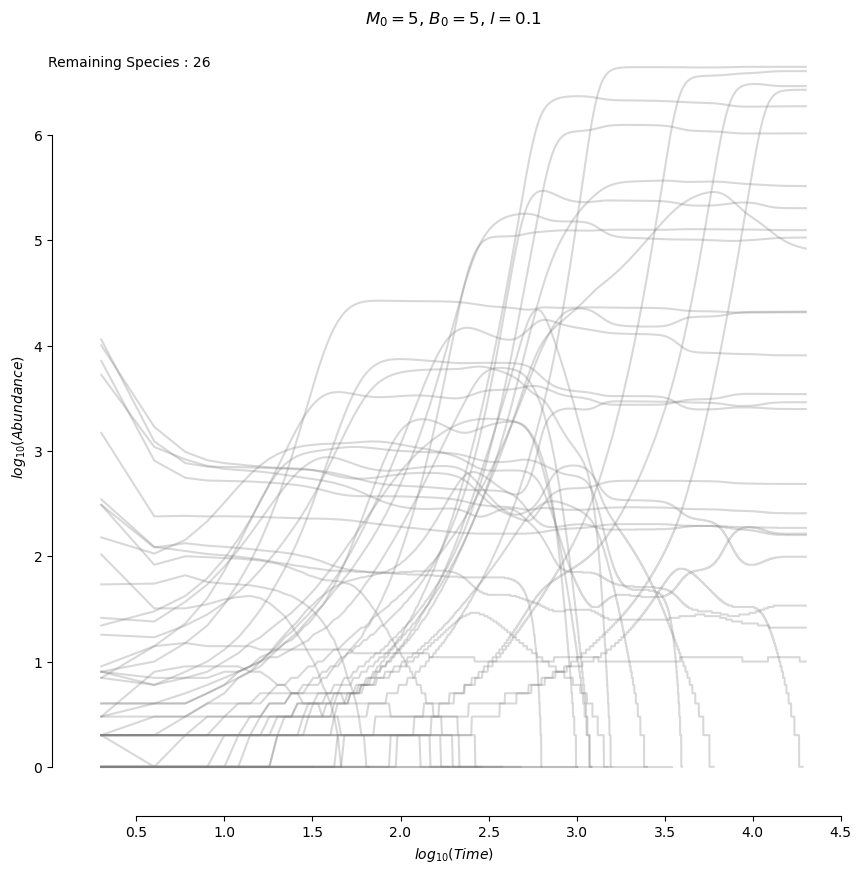

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_pop_trj(para, t, Ct, ax)

In [17]:
def plot_R(para, t, R, ax):
# plot species biomass trajectories
    np.seterr(divide = 'ignore')
    # plt.figure(figsize=(6, 6), dpi=300)
    for i in range(para.M):
        sns.lineplot(x=np.log10(t), y=np.log10(R[i, :]), color='grey', alpha=0.3, ax=ax)
    sns.despine(offset=10, trim=True)
    ax.set_title(f'$M_0 = {np.round(para.B0, 3)}$, $B_0 = {np.round(para.B0, 3)}$, $l = {np.round(para.l_base, 4)}$')
    ax.set_xlabel('$log_{10}(Time)$')
    ax.set_ylabel('$log_{10}(Abundance)$')
    # ax.text(0, max(np.log10(R).flatten()), f'Remaining resource : {len(R[R[:, -1]>0,-1])}')

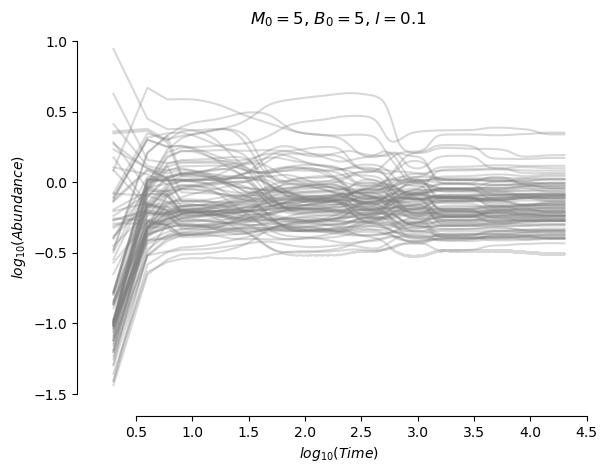

In [18]:
fig, ax = plt.subplots(1, 1)
plot_R(para, t, Rt, ax)

<Axes: >

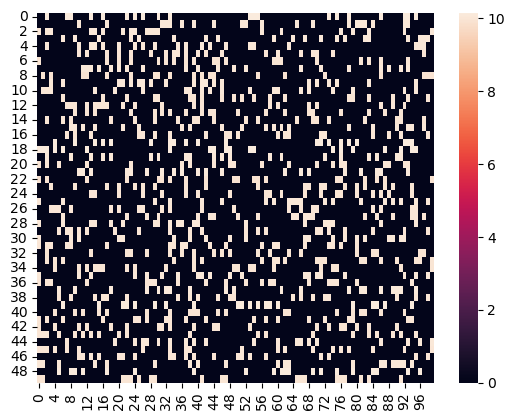

In [20]:
sns.heatmap(para.v_in_max)

<Axes: >

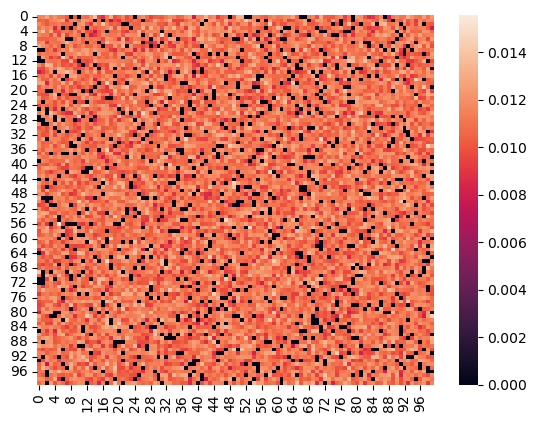

In [19]:
sns.heatmap(para.D)

In [11]:
D = np.zeros((10, 10))
values = np.random.normal(0.2, 0.2/10, 3) # sample conversion
x = np.arange(10)
np.random.shuffle(x)
idx = x[0:3]
D[1, idx] = np.random.normal(0.2, 0.2/10, 3)

In [99]:
rng = default_rng()
idx = rng.choice(range(10), size=5, replace=False)
print(idx)
len(idx) == len(set(idx))

[7 4 8 5 9]


True

# Variable scaling expoenents

In [3]:
N = 200
M = 100
para_sep = Paras(N, M)
scaling_exponents = np.linspace(0.5, 1.0, 10)
assemblenum = 1
subcommunity_size=50
num_subcommunity=1
list_exp = []
tstop = 30000
teval = 10000
tol = 1e-3

betas = [(0.5, x) for x in scaling_exponents]
alphas = [(x, 0.5) for x in scaling_exponents]

p, number = int_preferences(N, M, para_sep.mu_c, assemblenum)
D = int_conversion(M, para_sep.Dbase, para_sep.number, assemblenum, para_sep.sparsity)
l = int_l(M, para_sep.l_base, assemblenum)
rho = int_rho(M, para_sep.rho_base, assemblenum)
vmax = int_vmax(N, M, para_sep.v_max_base, p, number, assemblenum)
m = int_mt(N, para_sep.m_base, assemblenum)
avgm = allocate_avgm(N, para_sep.w, assemblenum, para_sep.ymin, para_sep.ymax)

In [4]:
def detect_steady_state(t, y, l, m, rho, mu, km, p, D, vmax, type, B0, M0, E0, alpha, beta, gamma, Rhalf, avgm, tol, N):
    '''_summary_

    Args:
        t (_type_): _description_
        y (_type_): _description_
        l (_type_): _description_
        m (_type_): _description_
        rho (_type_): _description_
        mu (_type_): _description_
        km (_type_): _description_
        p (_type_): _description_
        D (_type_): _description_
        vmax (_type_): _description_
        type (_type_): _description_
        B0 (_type_): _description_
        M0 (_type_): _description_
        E0 (_type_): _description_
        alpha (_type_): _description_
        beta (_type_): _description_
        gamma (_type_): _description_
        Rhalf (_type_): _description_
        avgm (_type_): _description_
        tol (_type_): _description_

    Returns:
        difference between two time step in y
    '''
    
    diff = odes_scale_size(t, y, l, m, rho, mu, km, p, D, vmax, type, B0, M0, E0, alpha, beta, gamma, Rhalf, avgm)
    l2_norm = sqrt(np.sum(diff[0:N]**2))
    # print(l2_norm)
    # print(tol)
    return l2_norm - tol

In [7]:
# multithreading func
def sim_fuc(name, N, M, para:Paras, assemblenum, tstop, teval, exp_pair, num_subcommunity, subcommunity_size, tol=1e-3, scale=True):
    
    # for integration
    logging.info("Thread %s: starting", name)

    # data storage
    R_assembles = []
    C_assembles = []
    t_assembles = []
    para_assembles = []
    identifier = []


    for i in range(num_subcommunity):
        
        para = Paras(subcommunity_size, M)
        ## select corresponding species for subcommunity assemblies
        rng = default_rng(seed=assemblenum+i+8*i)
        idx = rng.choice(range(N), size=subcommunity_size, replace=False)
        identifier.append(idx)
        new_p = p[idx, :]
        new_vmax = vmax[idx, :]
        new_m = m[idx, :]
        new_avgm = avgm[idx, :]

        ## Initialised Initial conditions
        R0 = int_R(M, para.R0, assemblenum)
        C0 = int_C(new_avgm, para.x0)

       # Load parametres
        para.paras(C0, R0, l, rho, new_p, new_vmax, new_m, D, new_avgm)
        time = np.linspace(0, tstop, teval)
        y0 = np.concatenate((R0, C0)).reshape(M+subcommunity_size,) # initial conditions

        # exp change
        para.alpha, para.beta = exp_pair
        # run and store
        if scale:
            pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.beta, para.gamma, para.R_half, para.avgm)

            odec = lambda t, y:odes_scale_size(t, y, *pars)
            detect_ss_odec = lambda t, y: detect_steady_state(t, y, *pars, tol=tol, N=subcommunity_size)
            detect_ss_odec.terminal = True
            detect_ss_odec.direction = -1
            
            result = solve_ivp(
            odec, t_span=[time[0], time[-1]], y0=y0, t_eval=time, events=detect_ss_odec, vectorized=True)
        
        if not scale:
            pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.R_half)
            result = solve_ivp(odes_not_scaled, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)
        
        Rt = result['y'][0:M]
        Ct = result['y'][M:M+subcommunity_size]
        t = result['t']

        print(f'Subcommunity simulation {i+1} completed runtime:{dt.datetime.now()-start}') # if (i+1)%5==0 else None


    R_assembles.append(Rt)
    C_assembles.append(Ct)
    t_assembles.append(t)
    para_assembles.append(para)

    logging.info("Thread %s: finishing", name)
    return R_assembles, C_assembles, t_assembles, para_assembles, identifier


In [8]:
# storing a file
if not os.path.exists('F:\Study\FYP\CellSizeBCAu\Data\\vexp'):
    os.makedirs('F:\Study\FYP\CellSizeBCAu\Data\\vexp')

for j in range(len(alphas)):

    logging.info(f'New pair started, Number {j+1}')
    Ra, Ca, ta, paraa, idxs = sim_fuc(j, N, M, para_sep, assemblenum, tstop, teval, alphas[j], num_subcommunity, subcommunity_size, tol=tol)

    dir = f'F:\Study\FYP\CellSizeBCAu\Data\\vexp\pair_{j+1}'

    if not os.path.exists(dir):
        os.mkdir(dir)

    for i in range(1, len(Ca)+1):

        with open(dir + f'\Ct{i}.npy', 'wb') as f:
            np.save(f, Ca[i-1])
        f.close()

        with open(dir + f'\Rt{i}.npy', 'wb') as f:
            np.save(f, Ra[i-1])
        f.close()

        with open(dir + f'\\t{i}.npy', 'wb') as f:
            np.save(f, ta[i-1])
        f.close()

        with open(dir + f'\para{i}.pkl', 'wb') as f:
            pkl.dump(paraa[i-1], f)
        f.close()

        with open(dir + f'\Id{i}.npy', 'wb') as f:
            np.save(f, idxs[i-1])
        f.close()
        logging.info(f'Pair Finished, Number {j+1}')

NameError: name 'start' is not defined

In [ ]:
Ca[0].shape

(50, 10000)